The purpose of this code is to quantify the size and number of synuclein inclusions for each image.

Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, binary_dilation, disk
import skimage.io as io
from skimage import exposure
from aicspylibczi import CziFile
from cellpose import models
model = models.Cellpose(model_type='cyto')

In [2]:
MIN_INCLUSION_SIZE = 10
MAX_INCLUSION_SIZE = 1500
COLOR_SCHEME = 'gray'

In [ ]:
def show_image(image):
    io.imshow(image, cmap='gray')
    plt.show()

def normalize_image(image):
    """Normalize the image to the range [0, 1]."""
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def preprocess_green_channel(green_channel):
    """Preprocess the green channel for cell segmentation and inclusion quantification."""
    confocal_img = gaussian(green_channel, sigma=2)
    confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.25)
    confocal_img = normalize_image(confocal_img)
    
    return confocal_img


def combine_tiles_images(image_list):
    """combine a 9 tiles image into a single image"""
    combined_image = np.zeros((image_list[0].shape[0] * 3, image_list[0].shape[1] * 3), dtype=image_list[0].dtype)
    for i, img in enumerate(image_list):
        row = i // 3
        col = i % 3
        combined_image[row * img.shape[0]:(row + 1) * img.shape[0], col * img.shape[1]:(col + 1) * img.shape[1]] = img
    return combined_image

def increase_contrast(image):
    """Increase the contrast of the image."""
    p2, p98 = np.percentile(image, (2, 98))
    return exposure.rescale_intensity(image, in_range=(p2, p98))


def normalize_image(image):
    """Normalize the image to the range [0, 1]."""
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def segment_cells(green_channel):
    """Segment cells in the green channel."""
    # increase contrast
    green_channel = increase_contrast(green_channel)
    # normalize
    green_channel = normalize_image(green_channel)
    mean_intensity = np.mean(green_channel[green_channel > 0.2])
    green_channel_remove_inclusions = np.where(green_channel < 0.6, green_channel, mean_intensity) # dim down inclusions
    green_channel_remove_inclusions = gaussian(green_channel_remove_inclusions, sigma=5) # blur
    # normalize
    green_channel_remove_inclusions = normalize_image(green_channel_remove_inclusions)

   
    # Detect cells in the green channel
    # keep increasing diameter until cells are detected
    diameter = 100

    while diameter < 700:

        masks, flows, styles, diams = model.eval(green_channel_remove_inclusions, diameter=diameter, channels=[0, 0])
        labeled_cells = label(masks)
        # if there are more than 0 cells
        if np.max(labeled_cells) > 0:
           
            return labeled_cells
        diameter += 25
    # no cells found, throw an error
    return np.zeros_like(green_channel)

def extract_inclusions(green_channel,mask,display_graph=False):

    green_channel = (green_channel - np.min(green_channel)) / ((np.max(green_channel) - np.min(green_channel)))
    applied_mask_blurred = gaussian(green_channel, sigma=1) * mask
    applied_mask_eliminate_background = applied_mask_blurred[applied_mask_blurred > 0] # filter out 0
    
    # normalize 
    applied_mask_eliminate_background = (applied_mask_eliminate_background - np.min(applied_mask_eliminate_background)) / ((np.max(applied_mask_eliminate_background) - np.min(applied_mask_eliminate_background)))

    # calculate statistics
    mean_intensity = np.mean(applied_mask_eliminate_background)
    median_intensity = np.median(applied_mask_eliminate_background)
    q1 = np.percentile(applied_mask_eliminate_background, 25)
    q3 = np.percentile(applied_mask_eliminate_background, 75)
    
    hist, bin_edges = np.histogram(applied_mask_eliminate_background, bins='fd')
    
    applied_mask = green_channel * mask
    # 0.5 is an empirical value that seems to work well
    if q3 < 0.5 and len(bin_edges) > 20:
        # the population is skewed to the left, indicating that there are inclusions
        threshold = threshold_otsu(green_channel[mask]) + 0.2 # use otsu thresholding to find the threshold
    elif q3 >= 0.7:
        # definitely no inclusions
        threshold = 1
    else:
        # probably no inclusions, but not sure, so we set a very high threshold in case there are inclusions
        threshold = 0.999
    
    
    inclusions = applied_mask > threshold # apply the threshold

    inclusions = remove_small_objects(inclusions, min_size=MIN_INCLUSION_SIZE) # remove small objects
    inclusions = inclusions ^ remove_small_objects(inclusions, min_size=MAX_INCLUSION_SIZE) # remove large objects

    if display_graph:
        
        print("Threshold: ", threshold)
        print("Bin count", len(bin_edges))

        plt.hist(applied_mask_eliminate_background, bins='fd')  
        plt.axvline(mean_intensity, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_intensity:.2f}')
        plt.axvline(median_intensity, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_intensity:.2f}')
        plt.axvline(q1, color='blue', linestyle='dashed', linewidth=2, label=f'Q1: {q1:.2f}')
        plt.axvline(q3, color='purple', linestyle='dashed', linewidth=2, label=f'Q3: {q3:.2f}')
        plt.axvline(threshold, color='orange', linestyle='dashed', linewidth=2, label=f'Threshold: {threshold:.2f}')
        plt.legend()
        plt.title("Intensity histogram")
        plt.show()


    return inclusions


def generate_inclusion_image(green_channel, labeled_cells):
    inclusion_image = np.zeros_like(green_channel)

    for i, cell in enumerate(regionprops(labeled_cells)):
        if cell.area < 100:
            continue
        
        mask = labeled_cells == cell.label
        
        inclusions = extract_inclusions(green_channel, mask)

        inclusion_image += inclusions
    # show_image(inclusion_image)
    return inclusion_image


In [4]:
def analyze_image(image_path, basename):
    
    # Load the image 
    czifile = CziFile(image_path)
    image = czifile.read_image()[0]
    image_squeezed = np.squeeze(image)
    
    print(f"Analyzing {basename}...")
    print(f"Image shape: {image_squeezed.shape}")
    # image = czifile.imread(image_path)
    # image_squeezed = np.squeeze(image)
    
    image_squeezed = combine_tiles_images(image_squeezed) 
    
    green_channel = image_squeezed
    green_channel = preprocess_green_channel(green_channel)

    print("Green Channel")
    show_image(green_channel)



    # Detect cells in the green channel
    labeled_cells = segment_cells(green_channel)
    print("Number of cells: ", len(np.unique(labeled_cells)) - 1)
    print("Segmented Cells")
    show_image(labeled_cells)


    # Initialize lists to store results
    cell_counter = []
    cell_size = []
    num_inclusions = []
    total_inclusion_areas = []
    average_inclusion_areas = []

    inclusion_areas_list = []
    inclusion_counter = []
    inclusion_counter_cells = []
    inclusions_image_list = []
    # combine all inclusion images
    all_inclusions = generate_inclusion_image(green_channel, labeled_cells)
    print("All Inclusions")
    show_image(all_inclusions)
    # Analyze each detected cell
    for i, cell in enumerate(regionprops(labeled_cells)):
        cell_counter.append(i)
        cell_size.append(cell.area)
        
        mask = labeled_cells == cell.label
        
    
        
        inclusions = all_inclusions * mask # get inclusions in the cell
        inclusions_labeled = label(inclusions)
        
        inclusion_areas = [inclusion.area for inclusion in regionprops(inclusions_labeled) if inclusion.area > 10 and inclusion.area < 1500] # filter out inclusions that are too small or too large
        inclusion_areas = np.array(inclusion_areas)
        total_inclusion_area = np.sum(inclusion_areas)
        average_inclusion_area = np.mean(inclusion_areas)

        
        # store results
        total_inclusion_areas.append(total_inclusion_area)
        num_inclusions.append(len(inclusion_areas))
        inclusion_areas_list.append(inclusion_areas)
        inclusion_counter.append(range(len(inclusion_areas)))
        inclusion_counter_cells.append([i] * len(inclusion_areas))
        average_inclusion_areas.append(average_inclusion_area)
    
    
    # analysis by image
    df1 = pd.DataFrame({
        "File_Name:": [basename],
        "Number_of_Inclusions": [np.sum(num_inclusions)],
        "Number_of_Cells": [len(cell_counter)],
        "Average_Inclusion_Count": [np.sum(num_inclusions)/len(cell_counter)],
    })
    
    # analysis by cell
    df2 = pd.DataFrame({
        "File_Name": [basename] * len(cell_counter),
        "Cell": cell_counter,
        "Num_Inclusions": num_inclusions
    })
    
    # analysis by inclusion
    if len(inclusion_counter) == 0:
        df3 = pd.DataFrame()
    else:
        df3 = pd.DataFrame({
            "File_Name": [basename] * len(np.concatenate(inclusion_counter)),
            "Inclusion": np.concatenate(inclusion_counter),
            "Cell": np.concatenate(inclusion_counter_cells),
            "Inclusion_Area": np.concatenate(inclusion_areas_list)
        })

    
    return df1, df2, df3


In [5]:
def analyze_all_images(image_folder):
    print(f"Analyzing images in folder: {image_folder}")
    all_data_1 = []
    all_data_2 = []
    all_data_3 = []
    for well_image in os.listdir(image_folder):
        
        if well_image.lower().endswith(".czi"):  # Filter for CZI files
            
            print(well_image)

            well_image_path = os.path.join(image_folder, well_image)
            well_image_base_name = os.path.basename(well_image)[:-4]
            
            df1, df2, df3 = analyze_image(well_image_path, well_image_base_name)
            all_data_1.append(df1)
            all_data_2.append(df2)
            all_data_3.append(df3)
            
            
            print("-" * 200)

    combined_df_1 = pd.concat(all_data_1, ignore_index=True)
    combined_df_1.to_excel(f"{image_folder[:5]}_analysis_by_image.xlsx", index=False)

    combined_df_2 = pd.concat(all_data_2, ignore_index=True)
    combined_df_2.to_excel(f"{image_folder[:5]}_analysis_by_cell.xlsx", index=False)

    combined_df_3 = pd.concat(all_data_3, ignore_index=True)
    combined_df_3.to_excel(f"{image_folder[:5]}_analysis_by_inclusion.xlsx", index=False)

Analyzing 1k_dox_dox+OA_feed_image_01...
Image shape: (9, 2146, 2146)
Green Channel


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


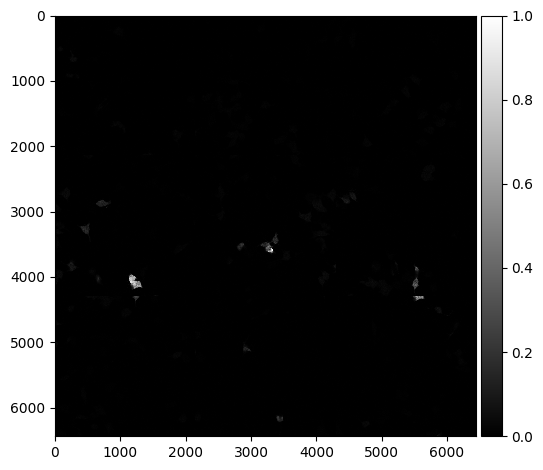

Number of cells:  319
Segmented Cells


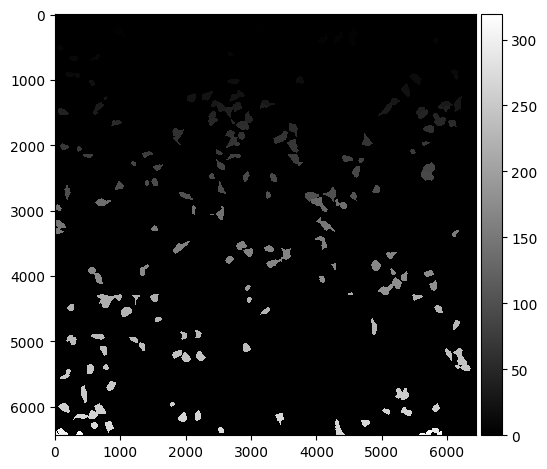

All Inclusions


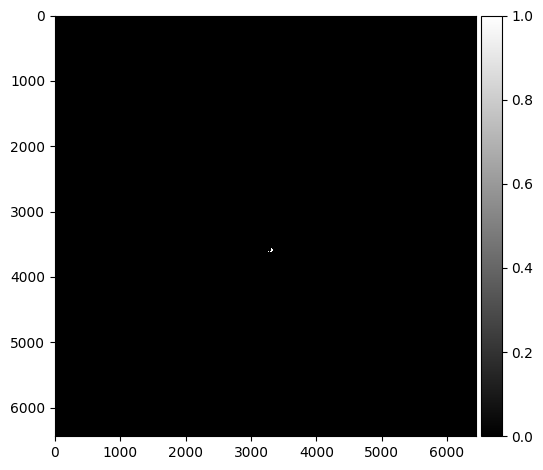

c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(                    File_Name:  Number_of_Inclusions  Number_of_Cells  \
 0  1k_dox_dox+OA_feed_image_01                     4              319   
 
    Average_Inclusion_Count  
 0                 0.012539  ,
                        File_Name  Cell  Num_Inclusions
 0    1k_dox_dox+OA_feed_image_01     0               0
 1    1k_dox_dox+OA_feed_image_01     1               0
 2    1k_dox_dox+OA_feed_image_01     2               0
 3    1k_dox_dox+OA_feed_image_01     3               0
 4    1k_dox_dox+OA_feed_image_01     4               0
 ..                           ...   ...             ...
 314  1k_dox_dox+OA_feed_image_01   314               0
 315  1k_dox_dox+OA_feed_image_01   315               0
 316  1k_dox_dox+OA_feed_image_01   316               0
 317  1k_dox_dox+OA_feed_image_01   317               0
 318  1k_dox_dox+OA_feed_image_01   318               0
 
 [319 rows x 3 columns],
                      File_Name  Inclusion   Cell  Inclusion_Area
 0  1k_dox_dox+OA_feed_i

In [6]:
# folders = ['data/120624_1k_wt_3k_tiles/1K_dox_dox+OA_OA_image_01.czi']

# for i in range(len(folders)):
#     analyze_all_images(folders[i])
analyze_image('data/120624_1k_wt_3k_tiles/1k_dox_dox+OA_feed_image_01.czi', '1k_dox_dox+OA_feed_image_01')
